epoch: 0 train loss:  2.8207042 val loss:  2.6185918 r2_score: -4.517900341411443
epoch: 10 train loss:  0.7675269 val loss:  0.6270528 r2_score: -0.6832961614346504
epoch: 20 train loss:  0.726445 val loss:  0.5490997 r2_score: -0.34369278547768656
epoch: 30 train loss:  0.7238677 val loss:  0.5429459 r2_score: -0.3360266476128846
epoch: 40 train loss:  0.714964 val loss:  0.54098105 r2_score: -0.3486409863941373
epoch: 50 train loss:  0.71569914 val loss:  0.53599817 r2_score: -0.338895267437211
epoch: 60 train loss:  0.712812 val loss:  0.5358332 r2_score: -0.34733737144885457
epoch: 70 train loss:  0.70545954 val loss:  0.5327156 r2_score: -0.3332217189149762
epoch: 80 train loss:  0.70840806 val loss:  0.53096795 r2_score: -0.32728780578618455
epoch: 90 train loss:  0.70341235 val loss:  0.5321618 r2_score: -0.3356254610577094


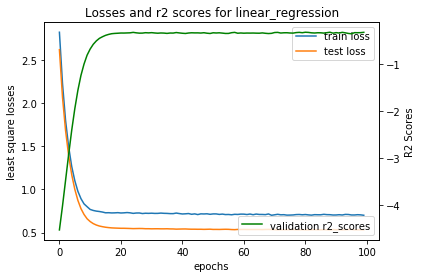

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import datetime
import os
from Imputer.knn_imputer import KNNImputer
import pdb
imagedir = 'images'
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
# For numeric stability
EPSILON = 1e-10

df = pd.read_csv(
    'ListingsAndSales.csv', parse_dates=['ListingDate', 'SalesDate'])

dataset_end = df['SalesDate'].max()

trn_end = pd.to_datetime('2015-02-01')
val_end = pd.to_datetime('2015-03-01')


def split_at(df, start_date=None, end_date=None):
    data_idx = np.ones(df.shape[0], dtype=bool)
    if start_date is not None:
        data_idx = data_idx & (df.ListingDate >= start_date)
    if end_date is not None:
        data_idx = data_idx & (df.ListingDate < end_date)
    return df.loc[data_idx, :].copy()


def scale(df, scaling_mean=None, scaling_std=None):
    numeric_features_train = df.select_dtypes(include=[np.number]).copy()
    if scaling_mean is None:
        scaling_mean, scaling_std = numeric_features_train.mean(
        ), numeric_features_train.std()
    numeric_features_train = (
        numeric_features_train - scaling_mean) / scaling_std
    return numeric_features_train, scaling_mean, scaling_std


def build_imputer(numeric_features_train):
    imputer = KNNImputer()
    imputer.fit(numeric_features_train)
    return imputer


def apply_imputer(features):
    features = features.copy()
    imputer.fill_in(features)
    return features


def build_Y(df, end):
    sold = df['SalesDate'] < end
    Y = df['SalesDate'].clip(upper=end).fillna(end) - df['ListingDate']
    return sold, Y.dt.days.astype(float)


class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)

        def build_loss(loss, loss_indicator):
            loss_numerator = tf.reduce_sum(loss * self.loss_indicator)
            loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
            return loss_numerator / loss_denominator

        RMSLE_raw = tf.sqrt(
            tf.reduce_mean(
                tf.square(
                    tf.log((self.output + EPSILON) / (self.y + EPSILON)))))
        self.RMSLE = build_loss(RMSLE_raw, self.loss_indicator)
        MAPE_raw = tf.reduce_mean(
            tf.abs(tf.log((self.output + EPSILON) / (self.y + EPSILON))))
        self.MAPE = build_loss(MAPE_raw, self.loss_indicator)

        self.optimizer = tf.train.AdamOptimizer().minimize(self.RMSLE)

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []

    def train_one_epoch(self, X_train, Y_train, sold_train, bs):
        # Train an epoch
        trn_loss = []
        # Randomly shuffle data and prepare for training
        trn_samples = X_train.shape[0]
        order = np.arange(trn_samples)
        np.random.shuffle(order)
        num_batches = (trn_samples // bs) + 1
        for itr in range(trn_samples // bs):
            rows = order[itr * bs:(itr + 1) * bs]
            if itr + 1 == num_batches:
                rows = order[itr * bs:]
            X_active, Y_active, Sold_active = [
                mat[rows] for mat in [X_train, Y_train, sold_train]
            ]
            feed_dict = {
                self.x: X_active,
                self.y: Y_active,
                self.sold: Sold_active
            }
            _, loss = self.sess.run([self.optimizer, self.RMSLE], feed_dict)
            trn_loss.append(loss)
        self.trn_losses.append(np.mean(trn_loss))

    def validate(self, X_test, Y_test, sold_test):
        feed_dict = {self.x: X_test, self.y: Y_test, self.sold: sold_test}
        val_loss, yhat = self.sess.run([self.RMSLE, self.output], feed_dict)
        self.val_losses.append(val_loss)
        self.r2_scores.append(r2_score(Y_test, yhat))

    def train(self, Xtrn, Xval, Ytrn, Yval, Soldtrn, Soldval, epochs, bs=64):
        # Everything is set. Now train and validate
        for epoch in range(epochs):
            # run one epoch train and validation
            self.train_one_epoch(Xtrn, Ytrn, Soldtrn, bs)
            self.validate(Xval, Yval, Soldval)

            if epoch % 10 == 0:
                # Occasionally print to command line to inspect performance
                print('epoch:', epoch, 'train loss: ', self.trn_losses[-1],
                      'val loss: ', self.val_losses[-1], 'r2_score:',
                      self.r2_scores[-1])

    def visualize(self, name):
        # Visualize training and validation losses and r2 scores on one plot
        _, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.trn_losses, label='train loss')
        ax1.plot(self.val_losses, label='test loss')
        ax2.plot(self.r2_scores, label='validation r2_scores', color='g')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('least square losses')
        ax2.set_ylabel('R2 Scores')
        ax2.legend()
        ax1.legend()
        plt.title('Losses and r2 scores for ' + name)
        plt.savefig(imagedir + '/' + name + '.jpg')
        plt.show()
        plt.show()


df_train = split_at(df, end_date=trn_end)
df_val = split_at(df, start_date=trn_end, end_date=val_end)

numeric_features_train, scaling_mean, scaling_std = scale(df_train)
numeric_features_val, _, _ = scale(df_val, scaling_mean, scaling_std)
nan_trn = numeric_features_train.isnull()
nan_val = numeric_features_val.isnull()
imputer = build_imputer(numeric_features_train)

trn_imputed = apply_imputer(numeric_features_train)
val_imputed = apply_imputer(numeric_features_val)

trn_imputed = pd.concat((trn_imputed, nan_trn.astype(float)), 1)
val_imputed = pd.concat((val_imputed, nan_val.astype(float)), 1)

trn_sold, trn_Y = build_Y(df_train, trn_end)

val_sold, val_Y = build_Y(df_val, dataset_end)

n_features = trn_imputed.shape[1]
model = Model(n_features, layer_sizes=[100])
model.train(
    trn_imputed.values,
    val_imputed.values,
    trn_Y.values,
    val_Y.values,
    trn_sold.values,
    val_sold.values,
    epochs=100)
model.visualize('linear_regression')



In [2]:
df_train

,ListingDate,SalesDate,ListPrice,SaleDollarCnt,ZestimateDollarCnt,BedroomCnt,BathroomCnt,FinishedSquareFeet,YearBuilt,MajorRemodelYear,StoryCnt,RoomTotalCnt,SFR,Latitude,Longitude,PageViews
0,2015-01-15,2015-01-30,740000.0,733000.0,667360.0,6.0,3.00,2730.0,1962.0,NaN,1.0,NaN,0,47675180,-122380500,625
5,2015-01-23,2015-02-26,475000.0,562000.0,547182.0,3.0,2.00,2510.0,1925.0,NaN,1.0,NaN,1,47563820,-122365570,1540
7,2015-01-28,2015-02-27,315000.0,330000.0,305831.0,1.0,1.00,612.0,2007.0,2007.0,6.0,NaN,1,47613196,-122316615,652
8,2015-01-31,2015-02-25,485000.0,522500.0,455433.0,4.0,3.00,2370.0,1977.0,NaN,1.0,NaN,1,47725764,-122306325,1143
9,2015-01-11,2015-01-29,140000.0,135000.0,146222.0,1.0,1.00,647.0,1982.0,1982.0,3.0,4.0,1,47691392,-122308407,577
14,2015-01-21,NaT,159900.0,NaN,147778.0,1.0,1.00,744.0,1979.0,1979.0,4.0,NaN,1,47696970,-122328238,238
15,2015-01-28,2015-02-27,315000.0,330000.0,305831.0,1.0,1.00,612.0,2007.0,2007.0,6.0,NaN,1,47613610,-122316720,638
17,2015-01-15,2015-02-06,725000.0,725000.0,279944.0,1.0,1.00,700.0,1949.0,NaN,1.0,NaN,1,47701635,-122340810,278
19,2015-01-06,NaT,439000.0,NaN,410765.0,3.0,2.25,3020.0,1994.0,NaN,3.0,NaN,1,47524707,-122318528,165
20,2015-01-29,2015-02-27,399950.0,420000.0,351597.0,3.0,2.00,2080.0,1963.0,NaN,1.0,NaN,1,47532173,-122290092,710
